In [1]:
from deepface import DeepFace
from deepface.commons import functions
from deepface.basemodels import VGGFace, Facenet, OpenFace, FbDeepFace, ArcFace, Facenet512, DeepID, DlibWrapper
from deepface.basemodels import SFaceWrapper
from deepface.basemodels.DlibResNet import DlibResNet
from deepface.commons import functions, distance as dst

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.datasets import fetch_lfw_pairs

from tqdm.autonotebook import tqdm
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pathlib
import json
import copy

In [41]:
models = {
  'SFace': SFaceWrapper.load_model,
  'Facenet': Facenet.loadModel,
  'Facenet512': Facenet512.loadModel,
  'VGG-Face': VGGFace.loadModel,
  'OpenFace': OpenFace.loadModel,
  'DeepFace': FbDeepFace.loadModel,
  'DeepID': DeepID.loadModel,
  'Dlib': DlibWrapper.loadModel,
  'ArcFace': ArcFace.loadModel,
}

distance_metrics = [
  "cosine",
  "euclidean",
  "euclidean_l2",
]

In [48]:
# for each model print the output shape
output_sizes = {}
for model_name, model in models.items():
    model = model()
    embedding = DeepFace.represent(img_path = "dataset/img/0_-M9l7X4fzA-gSGd--qsI.jpg", model_name = model_name, model = model)
    print(model_name, len(embedding))
    output_sizes[model_name] = len(embedding)

SFace 128
1/1 [==============================] - 1s 1s/step
Facenet 128
1/1 [==============================] - 1s 1s/step
Facenet512 512
1/1 [==============================] - 0s 214ms/step
VGG-Face 2622
1/1 [==============================] - 0s 471ms/step
OpenFace 128
1/1 [==============================] - 16s 16s/step
DeepFace 4096
1/1 [==============================] - 0s 57ms/step
DeepID 160
Dlib 128
1/1 [==============================] - 1s 597ms/step
ArcFace 512


In [49]:
# convert output_sizes to a dataframe
output_sizes = pd.DataFrame.from_dict(output_sizes, orient='index', columns=['output_size'])

In [53]:
# rename output_size to embedding_size
output_sizes.rename(columns={'output_size': 'embedding_size'}, inplace=True)

In [55]:
print(output_sizes.sort_values(by=['embedding_size'], ascending=False).to_latex())

\begin{tabular}{lr}
\toprule
{} &  embedding\_size \\
\midrule
DeepFace   &            4096 \\
VGG-Face   &            2622 \\
Facenet512 &             512 \\
ArcFace    &             512 \\
DeepID     &             160 \\
SFace      &             128 \\
Facenet    &             128 \\
OpenFace   &             128 \\
Dlib       &             128 \\
\bottomrule
\end{tabular}



In [2]:
lfw_pairs = fetch_lfw_pairs(subset = '10_folds', color = True, resize = 1)

X = lfw_pairs['pairs']
y = lfw_pairs['target']

# Split X and y intro 10 folds for cross validation
# X = np.split(X, 10)
# y = np.split(y, 10)

In [5]:
X.shape

(6000, 2, 125, 94, 3)

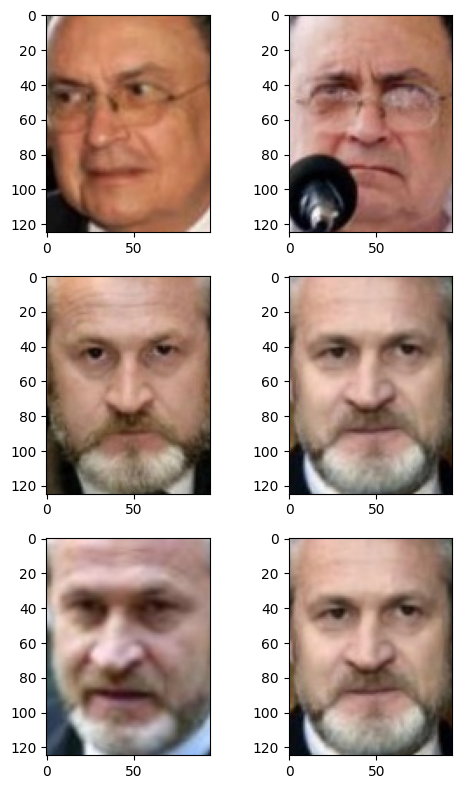

In [25]:
# 3x2 grid
fig, axs = plt.subplots(3, 2, figsize = (5, 8))
fig.tight_layout()

for i in range(3):
    for j in range(2):
        axs[i, j].imshow(X[i][j] / 255)

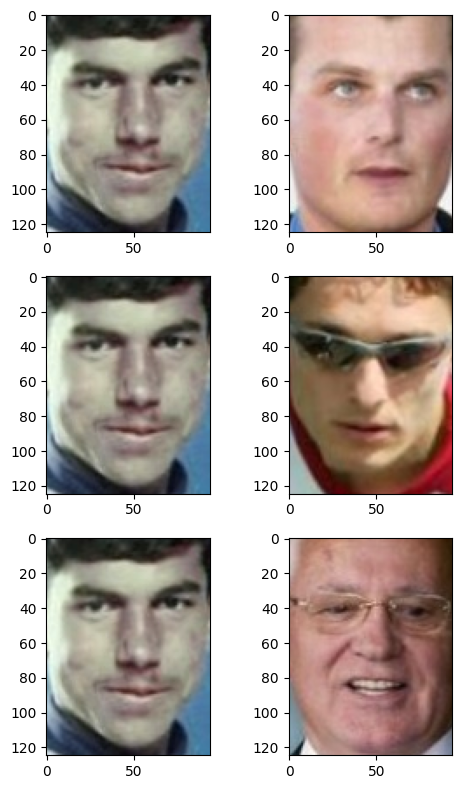

In [26]:
# 3x2 grid
fig, axs = plt.subplots(3, 2, figsize = (5, 8))
fig.tight_layout()

for i in range(3):
    for j in range(2):
        axs[i, j].imshow(X[i + 300][j] / 255)

In [4]:
# put X and y in a dataframe
df = pd.DataFrame({'pairs': list(X), 'y_true': y})

# split the pairs into two columns
df['img1'] = df['pairs'].apply(lambda x: x[0])
df['img2'] = df['pairs'].apply(lambda x: x[1])
df = df.drop(columns = ['pairs'], errors = 'ignore')

# convert to BGR
df['img1'] = df['img1'].apply(lambda x: x[...,::-1])
df['img2'] = df['img2'].apply(lambda x: x[...,::-1])

# split the dataframe into 10 folds
df['fold'] = np.repeat(np.arange(10), 600)

In [5]:
# %%capture
for model_name in tqdm(models.keys()):

  # create a folder for storing the results
  save_folder = f"results"
  pathlib.Path(save_folder).mkdir(parents=True, exist_ok=True)

  intermediary_folder = f"{save_folder}/intermediary"
  pathlib.Path(intermediary_folder).mkdir(parents=True, exist_ok=True)

  model = models[model_name]()

  df[f"{model_name}_img1"] = df['img1'].apply(lambda x: DeepFace.represent(img_path = x, model_name = model_name, model = model, enforce_detection=False, detector_backend='skip'))
  df[f"{model_name}_img2"] = df['img2'].apply(lambda x: DeepFace.represent(img_path = x, model_name = model_name, model = model, enforce_detection=False, detector_backend='skip'))

  # df[[f"{model_name}_img1", f"{model_name}_img2", "y_true"]].to_csv(f"{intermediary_folder}/{model_name}_representations.csv")

# df.to_csv(f"{save_folder}/representations.csv")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# # %%capture
# for model_name in tqdm(models.keys()):

#   # create a folder for storing the results
#   save_folder = f"results/{model_name}"
#   pathlib.Path(save_folder).mkdir(parents=True, exist_ok=True)

#   model = models[model_name]()

#   for fold in tqdm(range(10)):
#     curr_x = copy.deepcopy(X[fold])
#     curr_x = list(curr_x)
#     curr_x = [list(x) for x in curr_x]
#     # convert RGB to BGR
#     curr_x = [[img1[:, :, ::-1], img2[:, :, ::-1]] for img1, img2 in curr_x]

#     # create df for storing the results
#     df = pd.DataFrame(columns = ["img1_rep", "img2_rep"])

#     for img1, img2 in tqdm(curr_x):
#         img1_representation = DeepFace.represent(img_path = img1, model_name = model_name, model = model, enforce_detection=False)
        
#         img2_representation = DeepFace.represent(img_path = img2, model_name = model_name, model = model, enforce_detection=False)

#         obj = {
#             "img1_rep": [img1_representation],
#             "img2_rep": [img2_representation]
#         }

#         # add obj to df, ignore index
#         df = pd.concat([df, pd.DataFrame(obj)], axis = 0, ignore_index = True)

#     df["y_true"] = y[fold]
#     df.to_csv(f"{save_folder}/fold_{fold}.csv")

In [ ]:
for model in tqdm(models):
    csv_path = pathlib.Path(f"results/{model}")
    output_path = f"results_w_dst/{model}"
    pathlib.Path(output_path).mkdir(parents=True, exist_ok=True)

    # iterate over all csv files in the folder
    for csv_file in csv_path.iterdir():
        df = pd.read_csv(csv_file, index_col = 0, converters={"img1_rep": json.loads, "img2_rep": json.loads})

        # calculate the distance metrics
        df["dst_cosine"] = df.apply(lambda x: dst.findCosineDistance(x["img1_rep"], x["img2_rep"]), axis = 1)
        df["dst_euclidean"] = df.apply(lambda x: dst.findEuclideanDistance(x["img1_rep"], x["img2_rep"]), axis = 1)
        df["dst_euclidean_l2"] = df.apply(lambda x: dst.findEuclideanDistance(dst.l2_normalize(x["img1_rep"]), dst.l2_normalize(x["img2_rep"])), axis = 1)

        # compare distance metrics with threshold
        for distance_metric in distance_metrics:
            threshold = dst.findThreshold(model_name = model, distance_metric = distance_metric)
            df[f"y_pred_{distance_metric}"] = df[f"dst_{distance_metric}"] <= threshold

        # save the df
        df.to_csv(f"{output_path}/{csv_file.name}")

In [ ]:
for model in tqdm(models):
    csv_path = pathlib.Path(f"results_w_dst/{model}")
    print(csv_path, end="\t")
    
    for distance_metric in distance_metrics:
        print(distance_metric)
        accuracies = []
        precisions = []
        recalls = []
        f1s = []

        for csv_file in csv_path.iterdir():
            print(csv_file, end="\t")
            df = pd.read_csv(csv_file, index_col = 0, converters={"img1_rep": json.loads, "img2_rep": json.loads})

            y_true = df["y_true"]
            y_pred = df[f"y_pred_{distance_metric}"]

            accuracy = accuracy_score(y_true, y_pred)
            print(accuracy)

            accuracies.append(accuracy_score(y_true, y_pred))
            precisions.append(precision_score(y_true, y_pred))
            recalls.append(recall_score(y_true, y_pred))
            f1s.append(f1_score(y_true, y_pred))
        break
    break
        

In [ ]:
df1 = pd.read_csv("results/VGG-Face/fold_1.csv", index_col=0, converters={"img1_rep": json.loads, "img2_rep": json.loads})
df2 = pd.read_csv("results/VGG-Face/fold_2.csv", index_col=0, converters={"img1_rep": json.loads, "img2_rep": json.loads})

In [25]:
output_path = "results/distances"
pathlib.Path(output_path).mkdir(parents=True, exist_ok=True)

In [ ]:
for model_name in tqdm(models.key()):
    csv_path = f"results/intermediary/{model_name}_representations.csv"
    out_path = f"results/distances/{model_name}_distances.csv"

    img1_colname = f"{model_name}_img1"
    img2_colname = f"{model_name}_img2"

    df = pd.read_csv(f"results/intermediary/{model_name}_representations.csv", index_col=0, converters={img1_colname: json.loads, img2_colname: json.loads})

    # calculate the distance metrics
    df["dst_cosine"] = df.apply(lambda x: dst.findCosineDistance(x[img1_colname], x[img2_colname]), axis = 1)
    df["dst_euclidean"] = df.apply(lambda x: dst.findEuclideanDistance(x[img1_colname], x[img2_colname]), axis = 1)
    df["dst_euclidean_l2"] = df.apply(lambda x: dst.findEuclideanDistance(dst.l2_normalize(x[img1_colname]), dst.l2_normalize(x[img2_colname])), axis = 1)

    # compare distance metrics with threshold
    for distance_metric in distance_metrics:
        threshold = dst.findThreshold(model_name = model, distance_metric = distance_metric)
        df[f"y_pred_{distance_metric}"] = df[f"dst_{distance_metric}"] <= threshold
    
    df.to_csv(out_path)

In [26]:
model_name = "ArcFace"
img1_colname = f"{model_name}_img1"
img2_colname = f"{model_name}_img2"

df = pd.read_csv(f"results/intermediary/{model_name}_representations.csv", index_col=0, converters={img1_colname: json.loads, img2_colname: json.loads})

In [27]:
# calculate the distance metrics
df["dst_cosine"] = df.apply(lambda x: dst.findCosineDistance(x[img1_colname], x[img2_colname]), axis = 1)
df["dst_euclidean"] = df.apply(lambda x: dst.findEuclideanDistance(x[img1_colname], x[img2_colname]), axis = 1)
df["dst_euclidean_l2"] = df.apply(lambda x: dst.findEuclideanDistance(dst.l2_normalize(x[img1_colname]), dst.l2_normalize(x[img2_colname])), axis = 1)

In [28]:
# compare distance metrics with threshold
for distance_metric in distance_metrics:
    threshold = dst.findThreshold(model_name = model, distance_metric = distance_metric)
    df[f"y_pred_{distance_metric}"] = df[f"dst_{distance_metric}"] <= threshold

In [29]:
df

,ArcFace_img1,ArcFace_img2,y_true,fold,dst_cosine,dst_euclidean,dst_euclidean_l2,y_pred_cosine,y_pred_euclidean,y_pred_euclidean_l2
0,"[-0.0797523632645607, -0.2442759871482849, 0.3...","[0.002008344978094101, 0.019711630418896675, 0...",1,0,0.599894,4.424573,1.095348,False,False,False
1,"[0.08456815034151077, 0.44767656922340393, 0.2...","[0.12898048758506775, 0.13445737957954407, 0.2...",1,0,0.149392,2.437413,0.546611,True,False,True
2,"[-0.03844770789146423, 0.23183512687683105, 0....","[0.12898048758506775, 0.13445737957954407, 0.2...",1,0,0.250071,3.235290,0.707207,True,False,True
3,"[-0.05285981297492981, -0.2130700796842575, 0....","[-0.062213920056819916, -0.31474336981773376, ...",1,0,0.213947,2.964118,0.654136,True,False,True
4,"[0.021868718788027763, -0.08043141663074493, -...","[0.08960659056901932, -0.3001839518547058, -0....",1,0,0.383540,3.246519,0.875831,True,False,False
...,...,...,...,...,...,...,...,...,...,...
5995,"[0.0894065871834755, 0.04907173290848732, 0.08...","[0.012741170823574066, 0.050181444734334946, 0...",0,9,0.928053,5.286233,1.362389,False,False,False
5996,"[0.07310772687196732, -0.2640988528728485, -0....","[0.06938037276268005, 0.2236042320728302, 0.24...",0,9,1.138137,6.174652,1.508732,False,False,False
5997,"[-0.11841921508312225, 0.0693177655339241, 0.1...","[0.19952130317687988, 0.3386063873767853, 0.25...",0,9,0.925044,5.144968,1.360179,False,False,False
5998,"[-0.058107953518629074, 0.038464467972517014, ...","[-0.0300697460770607, -0.37665578722953796, -0...",0,9,0.873677,5.880486,1.321875,False,False,False


In [12]:
for model in tqdm(models):
    csv_path = pathlib.Path(f"results/{model}")
    output_path = f"results_w_dst/{model}"
    pathlib.Path(output_path).mkdir(parents=True, exist_ok=True)

    # iterate over all csv files in the folder
    for csv_file in csv_path.iterdir():
        df = pd.read_csv(csv_file, index_col = 0, converters={"img1_rep": json.loads, "img2_rep": json.loads})

        # calculate the distance metrics
        df["dst_cosine"] = df.apply(lambda x: dst.findCosineDistance(x["img1_rep"], x["img2_rep"]), axis = 1)
        df["dst_euclidean"] = df.apply(lambda x: dst.findEuclideanDistance(x["img1_rep"], x["img2_rep"]), axis = 1)
        df["dst_euclidean_l2"] = df.apply(lambda x: dst.findEuclideanDistance(dst.l2_normalize(x["img1_rep"]), dst.l2_normalize(x["img2_rep"])), axis = 1)

        # compare distance metrics with threshold
        for distance_metric in distance_metrics:
            threshold = dst.findThreshold(model_name = model, distance_metric = distance_metric)
            df[f"y_pred_{distance_metric}"] = df[f"dst_{distance_metric}"] <= threshold

        # save the df
        df.to_csv(f"{output_path}/{csv_file.name}")

list

In [97]:
res_accuracy_path = "results/accuracy"
pathlib.Path(res_accuracy_path).mkdir(parents=True, exist_ok=True)

res_df = pd.DataFrame(columns = ["model", "distance_metric", "accuracy", "accuracy_se", "precision", "precision_se", "recall", "recall_se", "f1", "f1_se"])

for model_name in tqdm(models.keys()):

    img1_colname = f"{model_name}_img1"
    img2_colname = f"{model_name}_img2"

    df = pd.read_csv(f"results/distances/{model_name}_distances.csv", index_col=0, converters={img1_colname: json.loads, img2_colname: json.loads})

    for distance_metric in distance_metrics:

        df[f"y_pred_{distance_metric}"] = df[f"y_pred_{distance_metric}"].astype(int)

        accuracies = []
        precisions = []
        recalls = []
        f1s = []

        for fold in range(10):
            df_fold = df[df["fold"] == fold]
            accuracy = accuracy_score(df_fold["y_true"], df_fold[f"y_pred_{distance_metric}"])
            accuracies.append(accuracy)
        
            precision = precision_score(df_fold["y_true"], df_fold[f"y_pred_{distance_metric}"])
            precisions.append(precision)

            recall = recall_score(df_fold["y_true"], df_fold[f"y_pred_{distance_metric}"])
            recalls.append(recall)

            f1 = f1_score(df_fold["y_true"], df_fold[f"y_pred_{distance_metric}"])
            f1s.append(f1)
            
        accuracy_mean = np.mean(accuracies)
        accuracy_se = np.std(accuracies, ddof=1) / np.sqrt(10)

        precision_mean = np.mean(precisions)
        precision_se = np.std(precisions, ddof=1) / np.sqrt(10)

        recall_mean = np.mean(recalls)
        recall_se = np.std(recalls, ddof=1) / np.sqrt(10)

        f1_mean = np.mean(f1s)
        f1_se = np.std(f1s, ddof=1) / np.sqrt(10)

        # concat the results
        res_df = pd.concat([res_df, pd.DataFrame({"model": model_name, "distance_metric": distance_metric, "accuracy": accuracy_mean, "accuracy_se": accuracy_se, "precision": precision_mean, "precision_se": precision_se, "recall": recall_mean, "recall_se": recall_se, "f1": f1_mean, "f1_se": f1_se}, index=[0])], ignore_index=True)

res_df.to_csv(f"{res_accuracy_path}/accuracy.csv")

  0%|          | 0/9 [00:00<?, ?it/s]

In [99]:
res_df.sort_values(by=["accuracy"], ascending=False)

,model,distance_metric,accuracy,accuracy_se,precision,precision_se,recall,recall_se,f1,f1_se
8,Facenet512,euclidean_l2,0.967833,0.001758,0.990272,0.001318,0.945000,0.004282,0.967040,0.001893
24,ArcFace,cosine,0.953167,0.004321,0.991705,0.001992,0.914000,0.008356,0.951085,0.004736
22,Dlib,euclidean,0.946167,0.003221,0.980097,0.004296,0.911000,0.005141,0.944175,0.003367
7,Facenet512,euclidean,0.944000,0.003154,0.994054,0.001679,0.893333,0.005578,0.940935,0.003453
26,ArcFace,euclidean_l2,0.935333,0.003717,0.996237,0.001667,0.874000,0.007434,0.930960,0.004267
23,Dlib,euclidean_l2,0.924167,0.002321,0.990856,0.003097,0.856333,0.004288,0.918614,0.002604
11,VGG-Face,euclidean_l2,0.876333,0.005442,0.825942,0.006604,0.954333,0.004446,0.885383,0.004754
21,Dlib,cosine,0.873833,0.003825,0.995249,0.001603,0.751333,0.008243,0.855993,0.005075
3,Facenet,cosine,0.865333,0.005310,0.998648,0.000689,0.731667,0.010660,0.844159,0.007133
9,VGG-Face,cosine,0.840833,0.004781,0.770854,0.005264,0.970667,0.004355,0.859193,0.003963


In [27]:
# load results/accuracy/accuracy.csv
res_df = pd.read_csv("results/accuracy/accuracy.csv", index_col=0)

In [39]:
# sort res_df by f1 score
res_df.sort_values(by=["f1"], ascending=False)

,model,distance_metric,accuracy,accuracy_se,precision,precision_se,recall,recall_se,f1,f1_se
8,Facenet512,euclidean_l2,0.967833,0.001758,0.990272,0.001318,0.945000,0.004282,0.967040,0.001893
24,ArcFace,cosine,0.953167,0.004321,0.991705,0.001992,0.914000,0.008356,0.951085,0.004736
22,Dlib,euclidean,0.946167,0.003221,0.980097,0.004296,0.911000,0.005141,0.944175,0.003367
7,Facenet512,euclidean,0.944000,0.003154,0.994054,0.001679,0.893333,0.005578,0.940935,0.003453
26,ArcFace,euclidean_l2,0.935333,0.003717,0.996237,0.001667,0.874000,0.007434,0.930960,0.004267
23,Dlib,euclidean_l2,0.924167,0.002321,0.990856,0.003097,0.856333,0.004288,0.918614,0.002604
11,VGG-Face,euclidean_l2,0.876333,0.005442,0.825942,0.006604,0.954333,0.004446,0.885383,0.004754
9,VGG-Face,cosine,0.840833,0.004781,0.770854,0.005264,0.970667,0.004355,0.859193,0.003963
21,Dlib,cosine,0.873833,0.003825,0.995249,0.001603,0.751333,0.008243,0.855993,0.005075
3,Facenet,cosine,0.865333,0.005310,0.998648,0.000689,0.731667,0.010660,0.844159,0.007133


In [28]:
res_df = res_df.sort_values(by=["accuracy"], ascending=False)

df = res_df.copy()
df["accuracy +/- SE"] = df["accuracy"].round(3).astype(str) + " +/- " + df["accuracy_se"].round(3).astype(str)
df["precision +/- SE"] = df["precision"].round(3).astype(str) + " +/- " + df["precision_se"].round(3).astype(str)
df["recall +/- SE"] = df["recall"].round(3).astype(str) + " +/- " + df["recall_se"].round(3).astype(str)
df["f1 +/- SE"] = df["f1"].round(3).astype(str) + " +/- " + df["f1_se"].round(3).astype(str)

In [8]:
df_latex = df[["model", "distance_metric", "accuracy +/- SE"]]

print(df_latex.to_latex(index=False))

\begin{tabular}{lll}
\toprule
     model & distance\_metric & accuracy +/- SE \\
\midrule
Facenet512 &    euclidean\_l2 & 0.968 +/- 0.002 \\
   ArcFace &          cosine & 0.953 +/- 0.004 \\
      Dlib &       euclidean & 0.946 +/- 0.003 \\
Facenet512 &       euclidean & 0.944 +/- 0.003 \\
   ArcFace &    euclidean\_l2 & 0.935 +/- 0.004 \\
      Dlib &    euclidean\_l2 & 0.924 +/- 0.002 \\
  VGG-Face &    euclidean\_l2 & 0.876 +/- 0.005 \\
      Dlib &          cosine & 0.874 +/- 0.004 \\
   Facenet &          cosine & 0.865 +/- 0.005 \\
  VGG-Face &          cosine & 0.841 +/- 0.005 \\
   ArcFace &       euclidean &  0.82 +/- 0.004 \\
     SFace &          cosine & 0.812 +/- 0.004 \\
   Facenet &       euclidean & 0.792 +/- 0.003 \\
Facenet512 &          cosine & 0.788 +/- 0.005 \\
     SFace &    euclidean\_l2 & 0.785 +/- 0.005 \\
   Facenet &    euclidean\_l2 & 0.773 +/- 0.004 \\
  VGG-Face &       euclidean & 0.728 +/- 0.006 \\
  DeepFace &       euclidean & 0.635 +/- 0.006 \\
  De

In [9]:
df_latex = df[["model", "distance_metric", "precision +/- SE", "recall +/- SE", "f1 +/- SE"]]

print(df_latex.to_latex(index=False))

\begin{tabular}{lllll}
\toprule
     model & distance\_metric & precision +/- SE &   recall +/- SE &       f1 +/- SE \\
\midrule
Facenet512 &    euclidean\_l2 &   0.99 +/- 0.001 & 0.945 +/- 0.004 & 0.967 +/- 0.002 \\
   ArcFace &          cosine &  0.992 +/- 0.002 & 0.914 +/- 0.008 & 0.951 +/- 0.005 \\
      Dlib &       euclidean &   0.98 +/- 0.004 & 0.911 +/- 0.005 & 0.944 +/- 0.003 \\
Facenet512 &       euclidean &  0.994 +/- 0.002 & 0.893 +/- 0.006 & 0.941 +/- 0.003 \\
   ArcFace &    euclidean\_l2 &  0.996 +/- 0.002 & 0.874 +/- 0.007 & 0.931 +/- 0.004 \\
      Dlib &    euclidean\_l2 &  0.991 +/- 0.003 & 0.856 +/- 0.004 & 0.919 +/- 0.003 \\
  VGG-Face &    euclidean\_l2 &  0.826 +/- 0.007 & 0.954 +/- 0.004 & 0.885 +/- 0.005 \\
      Dlib &          cosine &  0.995 +/- 0.002 & 0.751 +/- 0.008 & 0.856 +/- 0.005 \\
   Facenet &          cosine &  0.999 +/- 0.001 & 0.732 +/- 0.011 & 0.844 +/- 0.007 \\
  VGG-Face &          cosine &  0.771 +/- 0.005 & 0.971 +/- 0.004 & 0.859 +/- 0.004 

In [ ]:
df_latex = df[["model", "accuracy +/- SE"]]

print(df_latex.to_latex(index=False))

In [2]:
performance = {
    "FaceNet": 0.9963, # ok schroff facenet
    "DeepID": 0.9745, # ok sun deep
    "SFace": 0.9955, # ok boutros sface
    "ArcFace": 0.9953, # deng arcface
    "VGGFace": 0.9895, # parkhi deep
    "OpenFace": 0.9292, # amos openface
    "DeepFace": 0.9735, # taigman deepface
    "Human-level (original)": 0.9920, # kumar attribute
    "Human-level (cropped)": 0.9753, # kumar attribute
}

In [7]:
# convert performance to df
df_performance = pd.DataFrame.from_dict(performance, orient="index", columns=[ "accuracy"])

In [9]:
# change first column name df_performance to model
df_performance = df_performance.reset_index().rename(columns={"index": "model"})

In [12]:
# sort df_performance by accuracy
df_performance = df_performance.sort_values(by=["accuracy"], ascending=False)

In [13]:
# convert df_performance to latex
print(df_performance.to_latex(index=False))

\begin{tabular}{lr}
\toprule
                 model &  accuracy \\
\midrule
               FaceNet &    0.9963 \\
                 SFace &    0.9955 \\
               ArcFace &    0.9953 \\
Human-level (original) &    0.9920 \\
               VGGFace &    0.9895 \\
 Human-level (cropped) &    0.9753 \\
                DeepID &    0.9745 \\
              DeepFace &    0.9735 \\
              OpenFace &    0.9292 \\
\bottomrule
\end{tabular}



In [32]:
thresholds = {
    'VGG-Face': {'cosine': 0.40, 'euclidean': 0.60, 'euclidean_l2': 0.86},
    'Facenet':  {'cosine': 0.40, 'euclidean': 10, 'euclidean_l2': 0.80},
    'Facenet512':  {'cosine': 0.30, 'euclidean': 23.56, 'euclidean_l2': 1.04},
    'ArcFace':  {'cosine': 0.68, 'euclidean': 4.15, 'euclidean_l2': 1.13},
    'Dlib': 	{'cosine': 0.07, 'euclidean': 0.6, 'euclidean_l2': 0.4},

    #TODO: find the best threshold values
    'SFace': 	{'cosine': 0.5932763306134152, 'euclidean': 10.734038121282206, 'euclidean_l2': 1.055836701022614},

    'OpenFace': {'cosine': 0.10, 'euclidean': 0.55, 'euclidean_l2': 0.55},
    'DeepFace': {'cosine': 0.23, 'euclidean': 64, 'euclidean_l2': 0.64},
    'DeepID': 	{'cosine': 0.015, 'euclidean': 45, 'euclidean_l2': 0.17}

    }

In [33]:
# convert thresholds to df
df_thresholds = pd.DataFrame.from_dict(thresholds, orient="index", columns=[ "cosine", "euclidean", "euclidean_l2"])

In [37]:
# sort df_thresholds by model name
print(df_thresholds.sort_index().to_latex())

\begin{tabular}{lrrr}
\toprule
{} &    cosine &  euclidean &  euclidean\_l2 \\
\midrule
ArcFace    &  0.680000 &   4.150000 &      1.130000 \\
DeepFace   &  0.230000 &  64.000000 &      0.640000 \\
DeepID     &  0.015000 &  45.000000 &      0.170000 \\
Dlib       &  0.070000 &   0.600000 &      0.400000 \\
Facenet    &  0.400000 &  10.000000 &      0.800000 \\
Facenet512 &  0.300000 &  23.560000 &      1.040000 \\
OpenFace   &  0.100000 &   0.550000 &      0.550000 \\
SFace      &  0.593276 &  10.734038 &      1.055837 \\
VGG-Face   &  0.400000 &   0.600000 &      0.860000 \\
\bottomrule
\end{tabular}

